In [113]:
import numpy as np
import mir_eval

def sumChromaDifferences(chroma):
    # rearange chroma vector
    cq_fifth = np.zeros_like(chroma,dtype=float)
    for q in range(12):
        cq_fifth[:,q] = chroma[:,(q * 7) % 12]

    gamma_diff = np.zeros_like(chroma,dtype=float)
    for q in range(12):
        gamma_diff[:,q] = np.abs(cq_fifth[:,(q+1) % 12] - cq_fifth[:,q]) 
    # normalize to one
    gamma = 1- np.sum(gamma_diff,axis=1)/2
    return gamma

def negativeSlope(chroma):
    KSPARSE = 0.038461538461538464 # normalization constant
    gamma = np.zeros(chroma.shape[0],dtype=float)
    for t in range(chroma.shape[0]):
        y = np.sort(chroma[t,:])[::-1] # sort descending
        # linear regression using numpy
        A = np.vstack([np.arange(12), np.ones((12,))]).T
        k, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        #rescaled feature
        gamma[t] = 1 - np.abs(k)/KSPARSE
    return gamma

def shannonEntropy(chroma):
    """calculates the Shannon entropy of a chromagram for every timestep. The chromavector is treated as a random variable."""
    if chroma.shape[1] != 12:
        ax = 0
    else:
        ax = 1
    return -np.sum(np.multiply(chroma,np.log2(chroma+np.finfo(float).eps)), axis=ax)/np.log2(12)

def nonSparseness(chroma):
    norm_l1 = np.linalg.norm(chroma, ord=1,axis=1)
    norm_l2 = np.linalg.norm(chroma, ord=2,axis=1)
    gamma = 1 - ((np.sqrt(12)-norm_l1/norm_l2) / (np.sqrt(12)-1))
    return gamma

def flatness(chroma):
    geometric_mean = np.product(chroma,axis=1)**(1/12)
    arithmetic_mean = np.sum(chroma,axis=1) / 12
    return geometric_mean/arithmetic_mean

def angularDeviation(chroma):
    # rearange chroma vector in fifth
    cq_fifth = np.zeros_like(chroma,dtype=float)
    for q in range(12):
        cq_fifth[:,q] = chroma[:,(q * 7) % 12]

    angles = np.exp((2*np.pi*1j*np.arange(12))/12)
    angles = np.tile(angles,(chroma.shape[0],1)) # repeat vector
    gamma = np.abs(np.sum(cq_fifth*angles,axis=1))
    return np.sqrt(1- gamma)

# generate a test vector for chroma
sparse = np.zeros((12,),dtype=float)
sparse[0] = 1.0
triad = mir_eval.chord.quality_to_bitmap("maj")
tetrachord = mir_eval.chord.quality_to_bitmap("maj7")
flat = 1/12 * np.ones((12,),dtype=float)
chroma = np.array([sparse,triad,tetrachord,flat])
chroma = chroma / np.expand_dims(np.sum(chroma,axis=1),axis=1)

# sum of chroma differences (fifths)
sum_diff = sumChromaDifferences(chroma)

# standard deviation
std_dev = np.std(chroma,axis=1)

# negative slope 
slope = negativeSlope(chroma)

# entropy 
entropy = shannonEntropy(chroma)

# non sparseness feature 
sparse = nonSparseness(chroma)

# flatness
flat = flatness(chroma)

# angular deviation fifth ordered chroma
angular_dev = angularDeviation(chroma)



array([0.        , 0.59669879, 0.71905291, 1.        ])

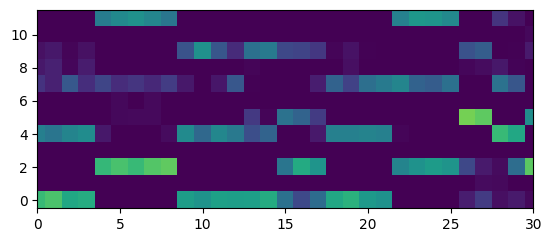

In [68]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from utils import buffer
from scipy.fftpack import dct,idct

# chroma feature
nCRP = 55 # bzw. vgl. mit  35 :);   % CRP(nCRP)
fs = 44100
N = int(4*8192)
overlap = N // 2
midi_note_start = 12
midi_note_stop = 120

k = np.arange(0,N//2 + 1)
fk = k*(fs/N)  # DFT-bin frequencies
midi_note_number_frequencies = 12* np.log2((fk/440)+np.finfo(float).eps)+69
Hp = np.zeros((fk.shape[0],midi_note_stop - midi_note_start),dtype=float)
for i, midi_note_number in enumerate(range(12,120)):
    d = np.abs(midi_note_number - midi_note_number_frequencies)
    Hp[:,i] = 0.5 * np.tanh(np.pi * (1 - 2*d)) + 0.5

if False:
    fig,ax = plt.subplots()
    ax.plot(fk,Hp[:,-8:-3])  # plot some of the halftone filters
    plt.title("Halftone Filters")
    ax.set_xlabel("Frequency in Hz")
    ax.set_xlim(5000,7000)

y,_ = librosa.load("/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/12_-_Let_It_Be/06_-_Let_It_Be.wav",sr = fs)
#y,_ = librosa.load("/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/12_-_Let_It_Be/03_-_Across_the_Universe.wav",sr = fs,duration = 10)

window = np.hanning(N)
y_blocks = buffer(y,N,overlap,0,window) 
weight = np.sum(window)
y_spectrum = (2/weight) * np.abs(np.fft.rfft(y_blocks,axis=0))
pitch_gram = np.matmul(Hp.T, y_spectrum) ** 2   # np.power(X,2) 
dt = np.linspace(0,y.shape[0]/fs,y_blocks.shape[1],10)
df = np.array(440*(2 ** ((np.linspace(midi_note_start,midi_note_stop,10)-69)/12)),dtype=int)
y_ticks = np.linspace(0,midi_note_stop-midi_note_start,10)


v = np.finfo(float).eps * np.ones((120,pitch_gram.shape[1]))
v[12:,:] = pitch_gram

vLog = np.log(100*v + 1);    # cf. CLP-Measure  .... diese Größe einfach zu Chroma zusammenfalten => quasi Lautheitsbewertet ...
vLogDCT = dct(vLog,norm='ortho',axis=0);  
vLogDCT[:nCRP,:] = 0  # liftering hochpass
vLogDCT[nCRP,:] = 0.5*vLogDCT[nCRP,:]

vLog_lift=idct(vLogDCT,norm='ortho',axis=0)
vLift = 1/100*(np.exp(vLog_lift)-1); 
crp = vLift.reshape(10,12,-1)
crp = np.maximum(0,np.sum(crp,axis=0))
crp = crp / np.sum(crp,axis=0)                        

fig,ax = plt.subplots()
img = ax.imshow(crp,origin='lower')
ax.set_xlim(0,30)
plt.show()
